## _Tracking Performance_

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import time

In [4]:
from sklearn.cluster import DBSCAN
from multiprocessing import Pool
from functools import partial
from utils_plot import make_cmp_plot, pt_configs, eta_configs

In [5]:
sys.path.append('..')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### _Read Particles HDF5 Store_

In [6]:
path = "../run_all/fwp_gnn_segmenting/eval/all_particles.h5"
store = pd.HDFStore(path)

In [7]:
# store.get('data').head()
df = store['data']

In [8]:
df.head()

,particle_id,pt,vx,vy,vz,q,pdgcode,theta,eta,n_true_hits,is_matched,is_trackable,evtid
0,6,0.205157,-1.854500,-0.415320,8.052530,1,2212,0.443487,1.489653,8,True,True,0
1,5,0.128648,2.395160,0.536402,6.411090,1,211,0.457441,1.457602,16,True,True,0
0,5,0.101602,-1.338330,1.013940,8.682130,1,211,0.451942,1.470122,11,True,True,1
1,6,0.275242,0.134011,-0.101529,0.468718,1,2212,0.501526,1.361974,14,True,True,1
0,5,0.114144,1.320080,0.160395,18.215401,1,211,0.447746,1.479773,23,True,True,10


In [9]:
pt = df.pt.values
eta = df.eta.values
vx = df.vx.values
vy = df.vy.values
d0 = np.sqrt(vx**2 + vy**2)
z0 = df.vz.values

rectable_idx = df.is_trackable
matched_idx = df.is_matched

In [10]:
max(d0), min(d0)

(21.71179, 0.00023630184)

In [11]:
# plot the efficiency as a function of pT, eta
make_cmp_plot_fn = partial(make_cmp_plot,
                           legends=["Generated", "Reconstructable", "Matched"],
                           ylabel="Events", ratio_label='Track Efficiency',
                           #ratio_legends=["Physics Eff.", "Technical Eff."])
                           ratio_legends=["Tracking Efficiency", "Tracking Efficiency (Tech.)"])

In [12]:
outdir = "./"
out_prefix = "plot_perf"

In [13]:
d0_bins = np.linspace(0.0, 20, num=20)   # will give 15 bins

d0_configs = {
    'bins': d0_bins,
    'histtype': 'step',
    'lw': 2,
    'log': False
}

cut_d0: 0.0


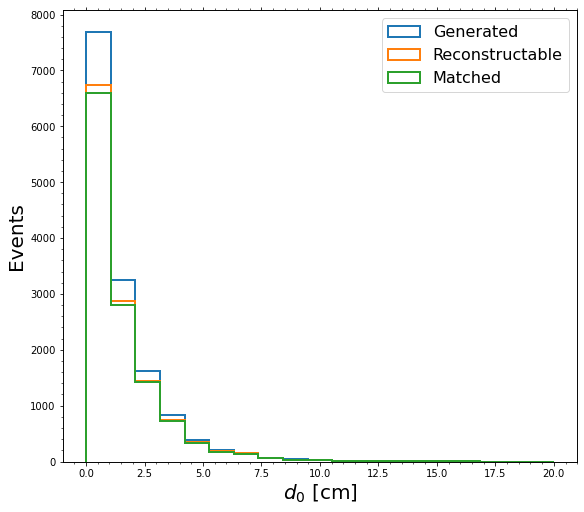

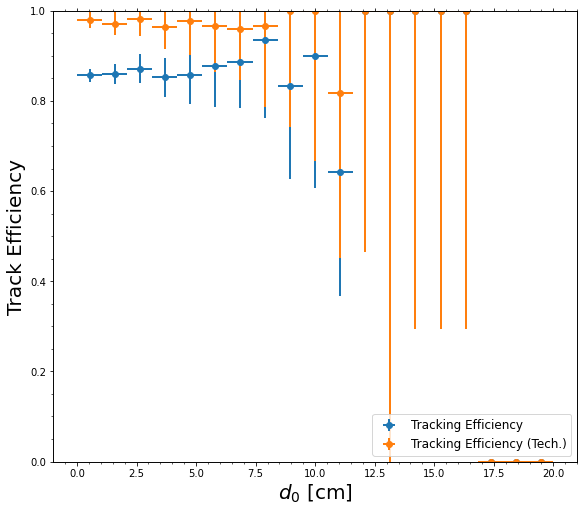

In [14]:
# vertex cuts
all_cuts = [0.0]

for (cut_d0) in all_cuts:
    print("cut_d0: {}".format(cut_d0))

    cuts = (d0 > cut_d0)

    # make pt plots
    gen_d0  = d0[cuts]
    true_d0 = d0[cuts & rectable_idx]
    reco_d0 = d0[cuts & rectable_idx & matched_idx]

    make_cmp_plot_fn([gen_d0, true_d0, reco_d0], 
        configs=d0_configs, xlabel=r"$d_0$ [cm]",
        outname=os.path.join(outdir, "{}_d0_cut{}".format(out_prefix, cut_d0)),
        ymin=0.6)

In [15]:
store.close()